In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


## _Prepration_

In [2]:
# Imports Modules

import os
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
import gc
warnings.filterwarnings("ignore")
!pip install feature_engine
from feature_engine.encoding import WoEEncoder



# Tools
from sklearn.preprocessing import LabelEncoder, power_transform, OneHotEncoder,StandardScaler,minmax_scale
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline




# Libraries
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier , RandomForestClassifier , ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV ,GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 490.0 kB/s eta 0:00:00


In [3]:
gc.enable

<function gc.enable()>

# _Data Import_

In [4]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv")
train_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [5]:
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')
test_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


# _Data Analyze_

In [6]:
all_features = train_df.drop(['id', 'failure'],axis=1).columns.tolist()
print(all_features, end='')

['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

In [7]:
def get_continuous_columns(dataframe,verbose=True):
    """
    Use this function to retun countinous  columns of a dataframe
    input : dataframe
    output: list 
    
    """
    
    continuos_column = []
    for column in dataframe.columns:
        if dataframe.dtypes[column] in ['float16' ,'float32' ,'float64']:
            continuos_column.append(column)
    print(f'There are {len(continuos_column)} continous  columns  in Datframe')
    print(continuos_column,end="")
    print("\n")
    return continuos_column

In [8]:
def get_categorical_columns(dataframe,verbose=True):
    """
    Use this function to retun categorical columns of a dataframe
    input : dataframe
    output: list 
    
    """
    categorical_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['int8' ,'int16',"int32" ,"int64" ,'uint8']:
            categorical_columns.append(column)
    print(f' There are {len(categorical_columns)} categorical columns in Dataframe',end='')
    print(categorical_columns,end='')
    print("\n")
    return categorical_columns

In [9]:
def get_object_columns(dataframe,verbose=True):
    """
    Use this function to retun object columns of a dataframe
    input : dataframe
    output: list 
    
    """
    object_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['object']:
            object_columns.append(column)
    print(f' There are {len(object_columns)} Objective columns in Dataframe',end='')
    print(object_columns,end='')
    print("\n")
    return object_columns

In [10]:
# Identify Categorial Columns
cat_columns = get_categorical_columns(train_df[all_features])

 There are 5 categorical columns in Dataframe['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2']



In [11]:
# Identify Continuos Columns
cont_columns = get_continuous_columns(train_df[all_features])

There are 16 continous  columns  in Datframe
['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']



In [12]:
# Identify Objective Columns
obj_columns = get_object_columns(train_df[all_features])

 There are 3 Objective columns in Dataframe['product_code', 'attribute_0', 'attribute_1']



In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,26570.0,13284.500000,7670.242662,0.000,6642.25000,13284.5000,19926.75000,26569.000
loading,26320.0,127.826233,39.030020,33.160,99.98750,122.3900,149.15250,385.860
attribute_2,26570.0,6.754046,1.471852,5.000,6.00000,6.0000,8.00000,9.000
attribute_3,26570.0,7.240459,1.456493,5.000,6.00000,8.0000,8.00000,9.000
measurement_0,26570.0,7.415883,4.116690,0.000,4.00000,7.0000,10.00000,29.000
measurement_1,26570.0,8.232518,4.199401,0.000,5.00000,8.0000,11.00000,29.000
measurement_2,26570.0,6.256568,3.309109,0.000,4.00000,6.0000,8.00000,24.000
measurement_3,26189.0,17.791528,1.001200,13.968,17.11700,17.7870,18.46900,21.499
measurement_4,26032.0,11.731988,0.996085,8.008,11.05100,11.7330,12.41000,16.484
measurement_5,25894.0,17.127804,0.996414,12.073,16.44300,17.1320,17.80500,21.425


In [14]:
# Missing Rates
def missing_rate(data_frame):
    missing_rate = {}
    for col in data_frame.columns:
        column_missing_rate = data_frame[col].isna().sum() / len(data_frame[col]) * 100
        missing_rate[col] = round(column_missing_rate,2)
    missing_rate = pd.DataFrame(missing_rate.items(), index=None)
    return missing_rate

In [15]:
missing_rate_train = missing_rate(train_df)

In [16]:
missing_rate_test = missing_rate(test_df)

In [17]:
pd.concat([missing_rate_train[0].rename("Features"),missing_rate_train[1].rename("Train Mssing rate"),missing_rate_test[1].rename("Test Missing Rate")],axis=1)

,Features,Train Mssing rate,Test Missing Rate
0,id,0.00,0.00
1,product_code,0.00,0.00
2,loading,0.94,1.07
3,attribute_0,0.00,0.00
4,attribute_1,0.00,0.00
5,attribute_2,0.00,0.00
6,attribute_3,0.00,0.00
7,measurement_0,0.00,0.00
8,measurement_1,0.00,0.00
9,measurement_2,0.00,0.00


In [18]:
measurment_missings = pd.concat([train_df[cont_columns].isna().sum().rename('missing values in train'),
           round(train_df[cont_columns].isna().sum() / len(train_df[cont_columns]) * 100,2).rename("Missin Rate Train"),
           test_df[cont_columns].isna().sum().rename('missing values in test'),
          round(test_df[cont_columns].isna().sum() / len(test_df[cont_columns]) * 100,2).rename("Missin Rate Test")],
          axis=1)
measurment_missings

,missing values in train,Missin Rate Train,missing values in test,Missin Rate Test
loading,250,0.94,223,1.07
measurement_3,381,1.43,329,1.58
measurement_4,538,2.02,409,1.97
measurement_5,676,2.54,508,2.45
measurement_6,796,3.00,624,3.00
measurement_7,937,3.53,720,3.47
measurement_8,1048,3.94,846,4.07
measurement_9,1227,4.62,904,4.35
measurement_10,1300,4.89,1067,5.14
measurement_11,1468,5.53,1136,5.47


In [19]:
cardinality_train = train_df[obj_columns + cat_columns].nunique()
cardinality_train

product_code      5
attribute_0       2
attribute_1       3
attribute_2       4
attribute_3       4
measurement_0    29
measurement_1    30
measurement_2    25
dtype: int64

In [20]:
cardinality_test = train_df[obj_columns + cat_columns].nunique()
cardinality_test

product_code      5
attribute_0       2
attribute_1       3
attribute_2       4
attribute_3       4
measurement_0    29
measurement_1    30
measurement_2    25
dtype: int64

In [21]:
data_cardinality = pd.concat([pd.DataFrame(cardinality_train.rename("Train Cardinality")),pd.DataFrame(cardinality_test.rename("Test Cardinality"))],axis=1)
data_cardinality

,Train Cardinality,Test Cardinality
product_code,5,5
attribute_0,2,2
attribute_1,3,3
attribute_2,4,4
attribute_3,4,4
measurement_0,29,29
measurement_1,30,30
measurement_2,25,25


# _EDA_

<AxesSubplot:xlabel='failure', ylabel='Count'>

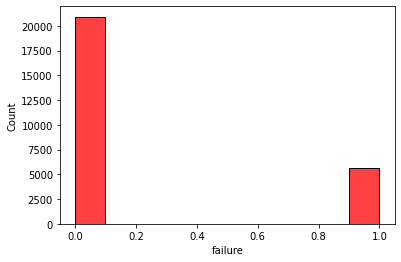

In [22]:
# Distrbution of Failure
sns.histplot(data=train_df['failure'],palette="viridis",bins=10,color="red")


In [23]:
# Percenatege of Failure
target_pecentage = pd.DataFrame(train_df['failure'].value_counts() / len(train_df.failure))
target_pecentage.T

,0,1
failure,0.787392,0.212608


Text(0.5, 1.0, 'Target distribution')

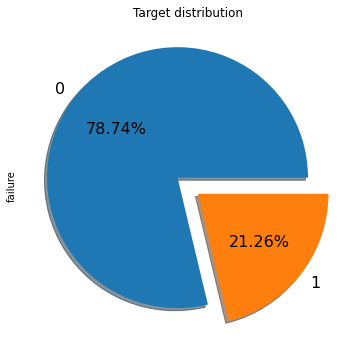

In [24]:
plt.figure(figsize=(6,6))
train_df['failure'].value_counts().plot.pie(explode=[0.10,0.1], autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

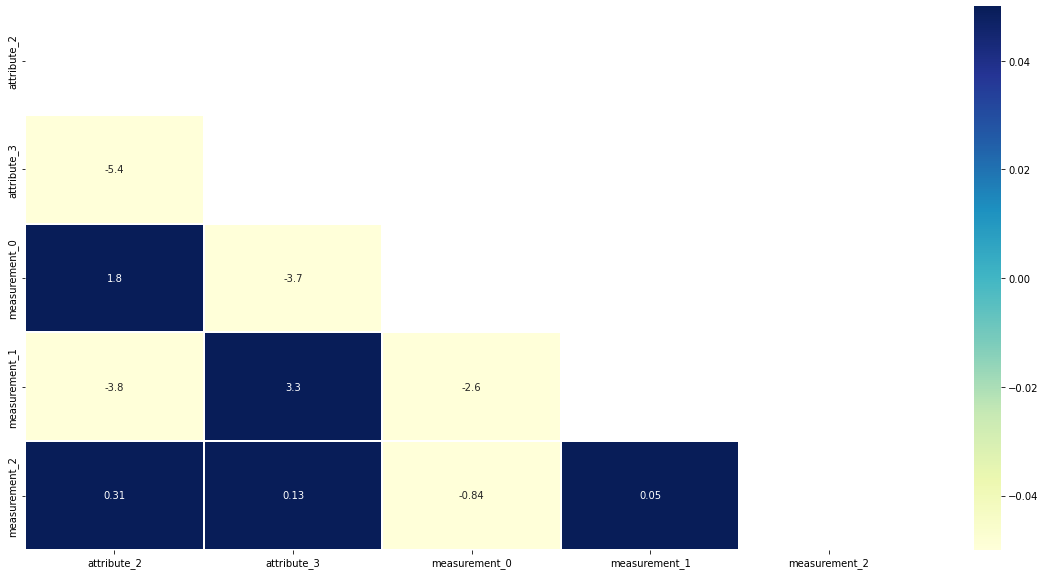

In [25]:
# Categorial Corrilation
matrix = np.triu(train_df[cat_columns].corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df[cat_columns].corr() * 10 , annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

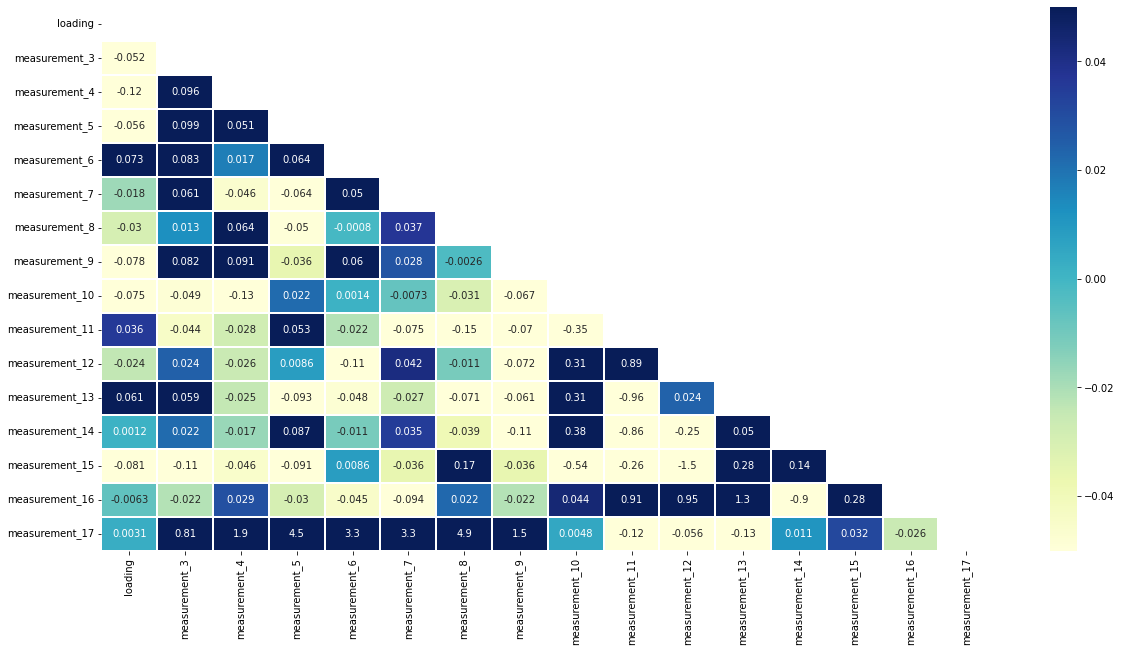

In [26]:
# Continous columns Corrilation

matrix = np.triu(train_df[cont_columns].corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df[cont_columns].corr() * 10, annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

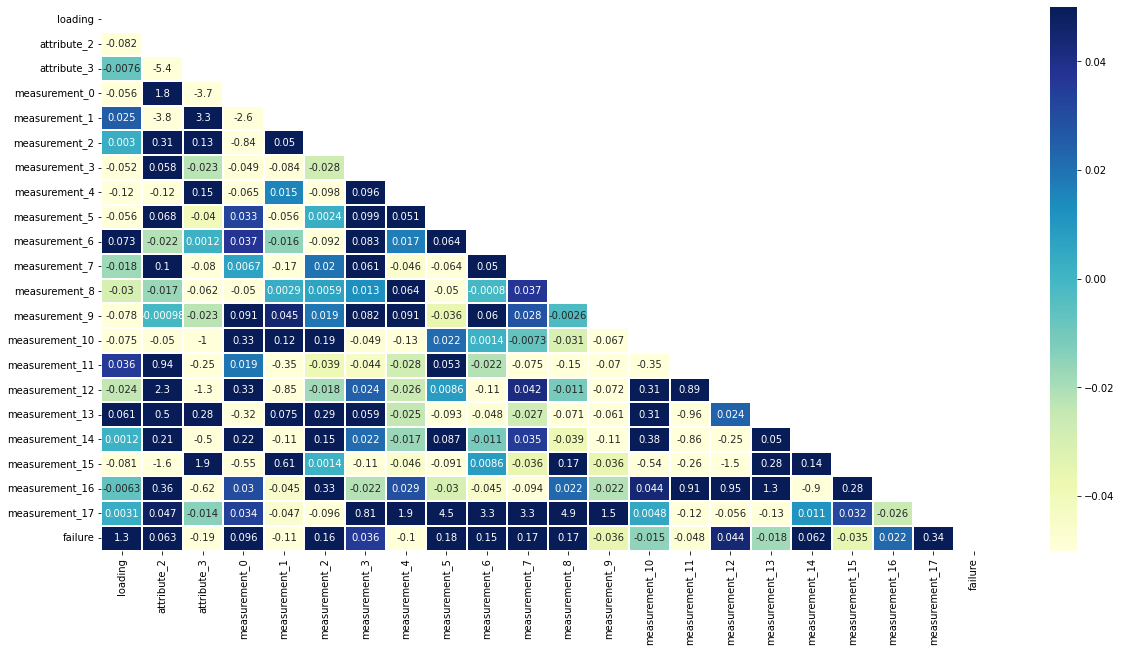

In [27]:
# All Feautre Corr
matrix = np.triu(train_df.drop("id" , axis=1).corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df.drop("id", axis=1).corr() * 10 , annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

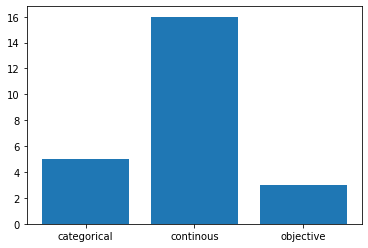

In [28]:
plt.bar([1,2,3], [len(cat_columns) ,len(cont_columns),len(obj_columns)])
plt.xticks([1,2,3] , ['categorical' , 'continous','objective'])
plt.show()

In [29]:
%%time
train_df.shape , test_df.shape

CPU times: user 39 µs, sys: 8 µs, total: 47 µs
Wall time: 51.7 µs


((26570, 26), (20775, 25))

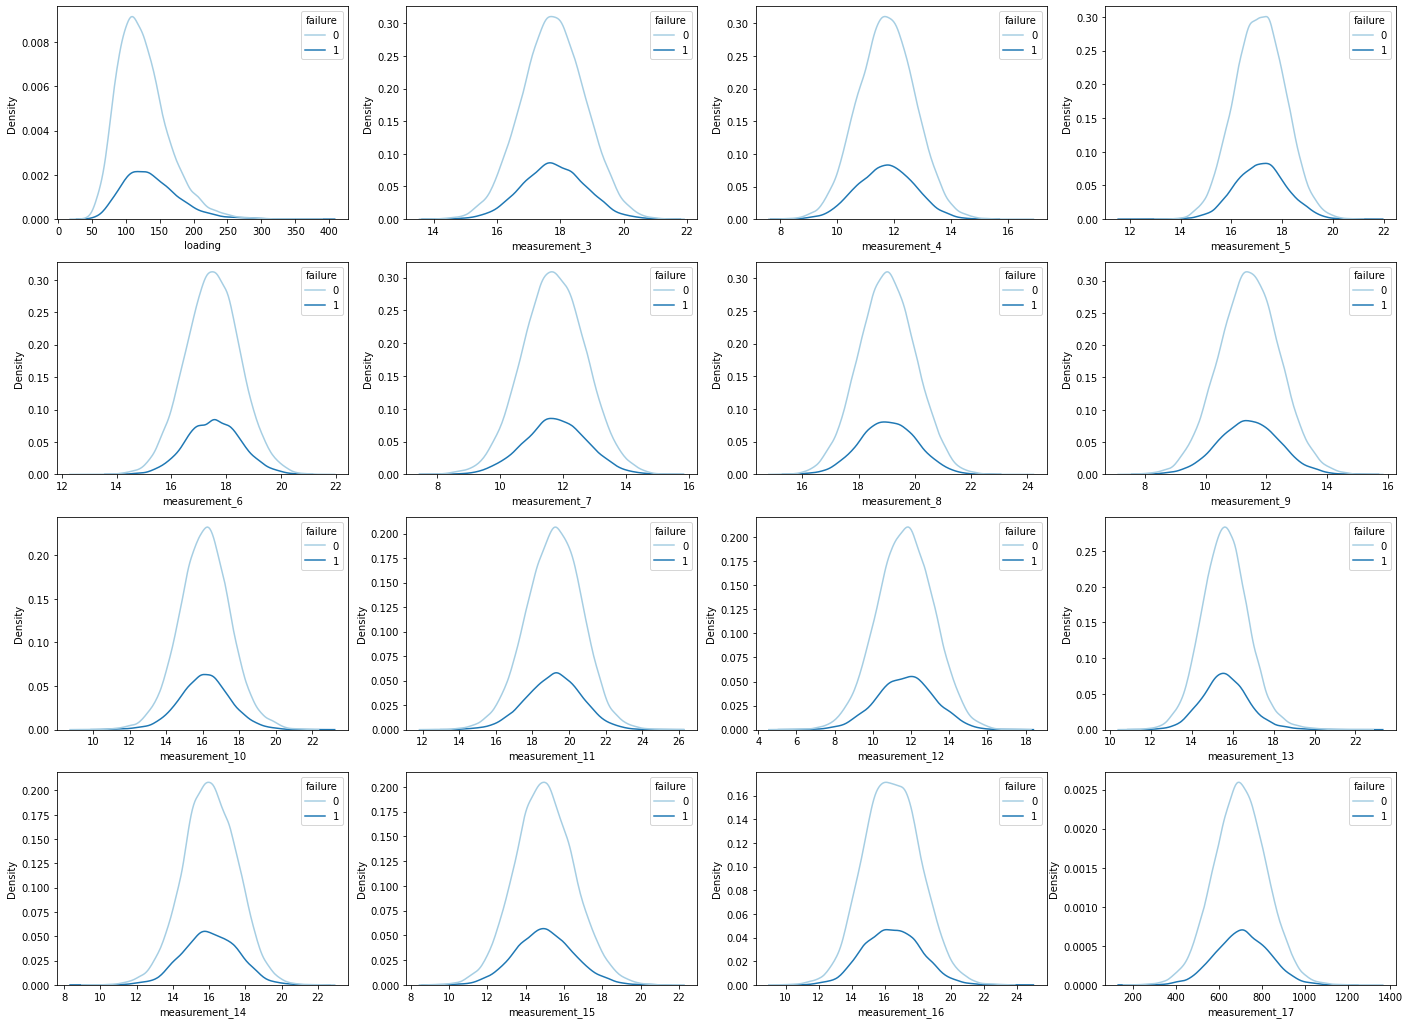

In [30]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cont_columns):
    plt.subplot(4,4,n+1)
    sns.kdeplot(data=train_df,x=feature,hue="failure",palette=sns.color_palette("Paired",2))

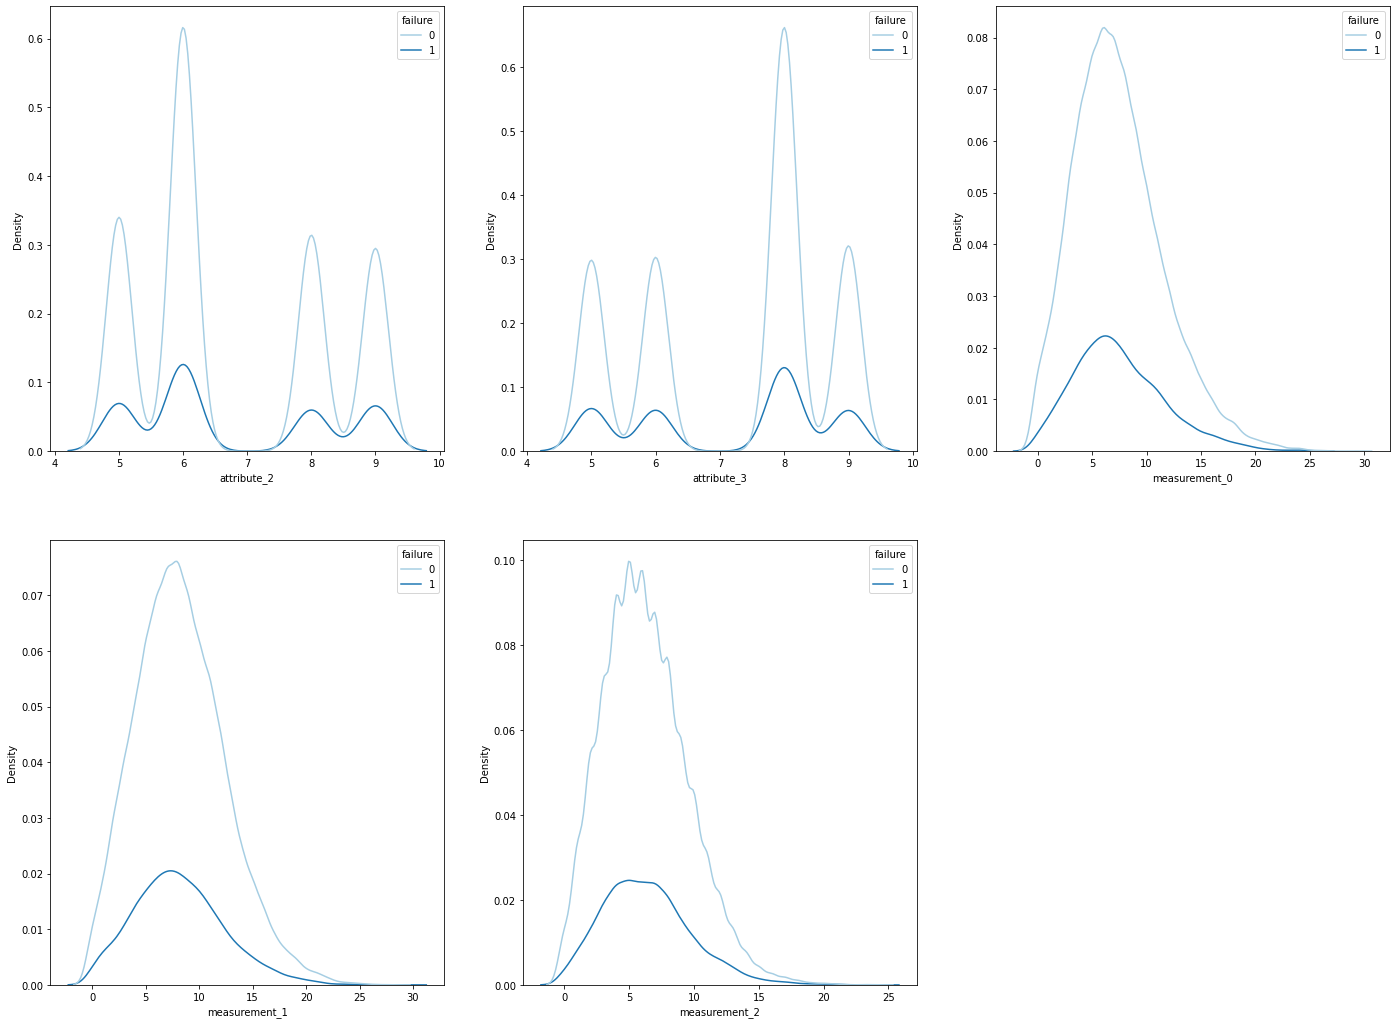

In [31]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cat_columns):
    plt.subplot(2,3,n+1)
    sns.kdeplot(data=train_df,x=feature,hue="failure",palette=sns.color_palette("Paired",2))

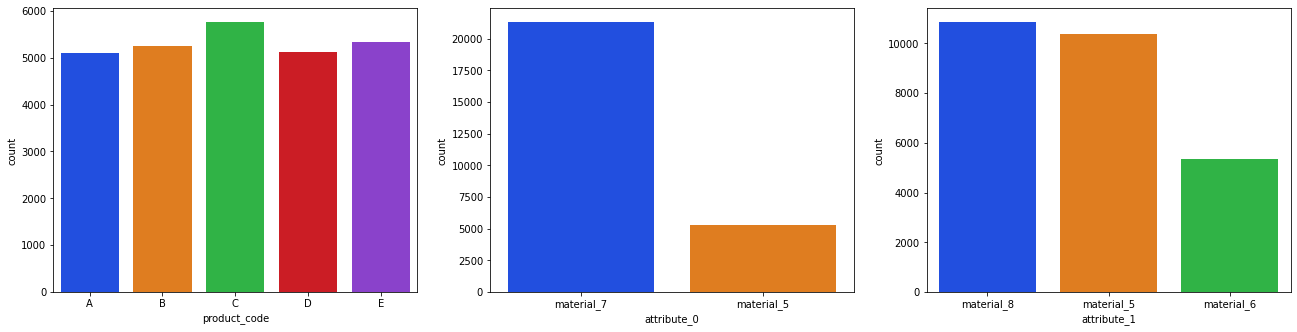

In [32]:
fig, axes = plt.subplots(figsize=(30,24))
for n,feature in enumerate(obj_columns):
    plt.subplot(4,4,n+1)
    sns.countplot(data=train_df,x=feature,palette=sns.color_palette("bright"))

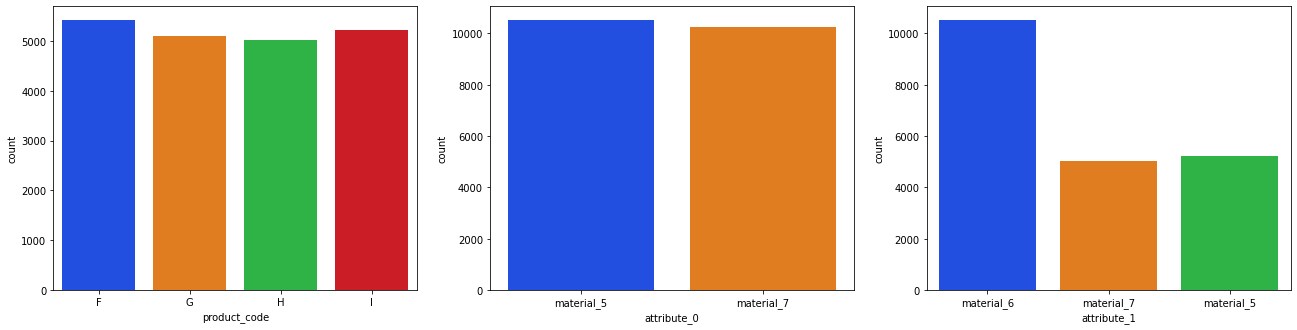

In [33]:
fig, axes = plt.subplots(figsize=(30,24))
for n,feature in enumerate(obj_columns):
    plt.subplot(4,4,n+1)
    sns.countplot(data=test_df,x=feature,palette=sns.color_palette("bright",))

# Compare Train and Test

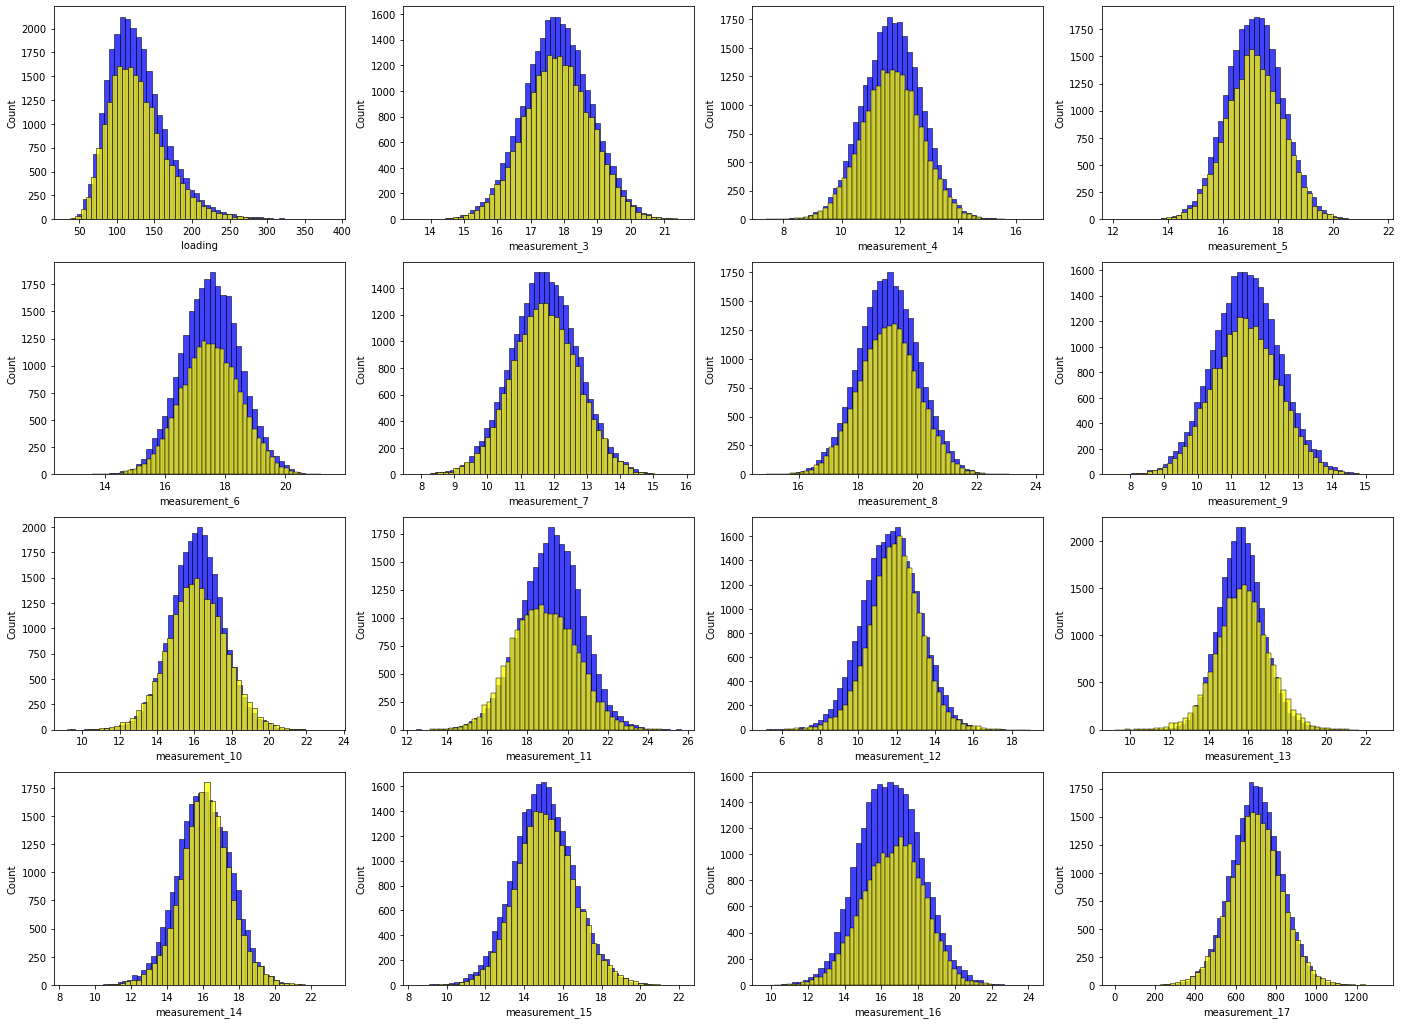

In [34]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cont_columns):
    plt.subplot(4,4,n+1)
    sns.histplot(data=train_df,x=feature,color='blue',label="train",bins=50,palette="bright")
    sns.histplot(data=test_df,x=feature,color='yellow',label="train",bins=50,palette="bright")

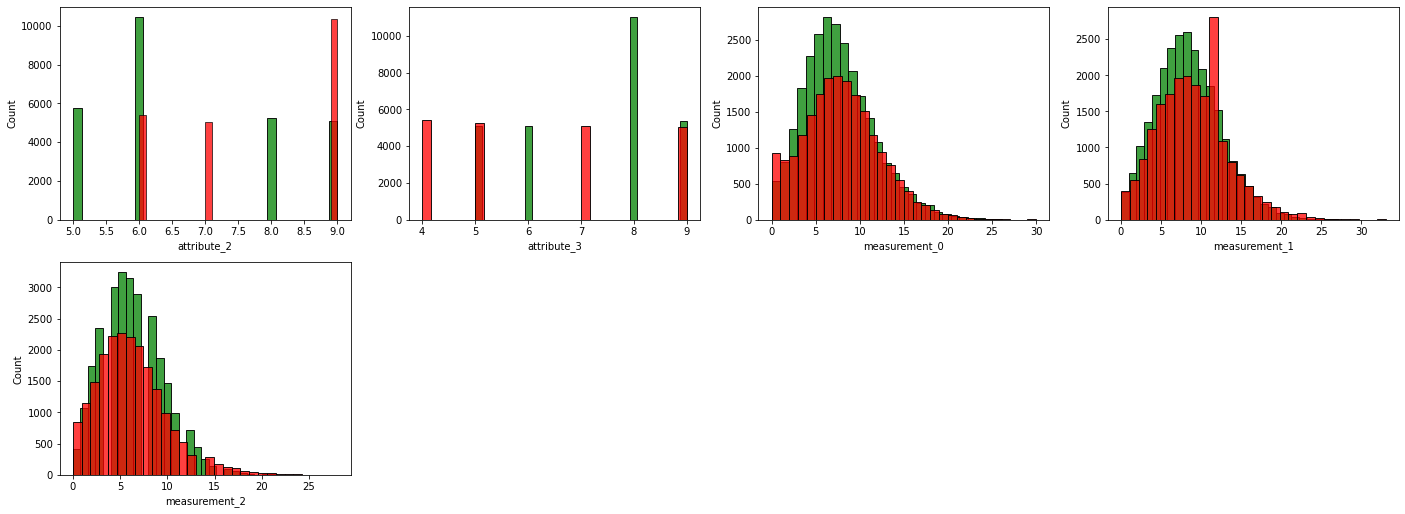

In [35]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cat_columns):
    plt.subplot(4,4,n+1)
    sns.histplot(data=train_df,x=feature,color='green',label="train",bins=30,palette="paired")
    sns.histplot(data=test_df,x=feature,color='red',label="train",bins=30,palette="paired")

# Pre Process

In [36]:
# Product Categories
product_types = train_df['product_code'].unique().tolist() + test_df['product_code'].unique().tolist()
product_types

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [37]:
# Concatenate Train,Test
data = pd.concat([train_df[all_features],test_df[all_features]])
data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


In [38]:
data.shape

(47345, 24)

In [39]:
# Measurments
measurments = [col for col in data.columns if str(data[col].name).startswith('m')]
measurments

['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [40]:
measured_data = data[measurments]

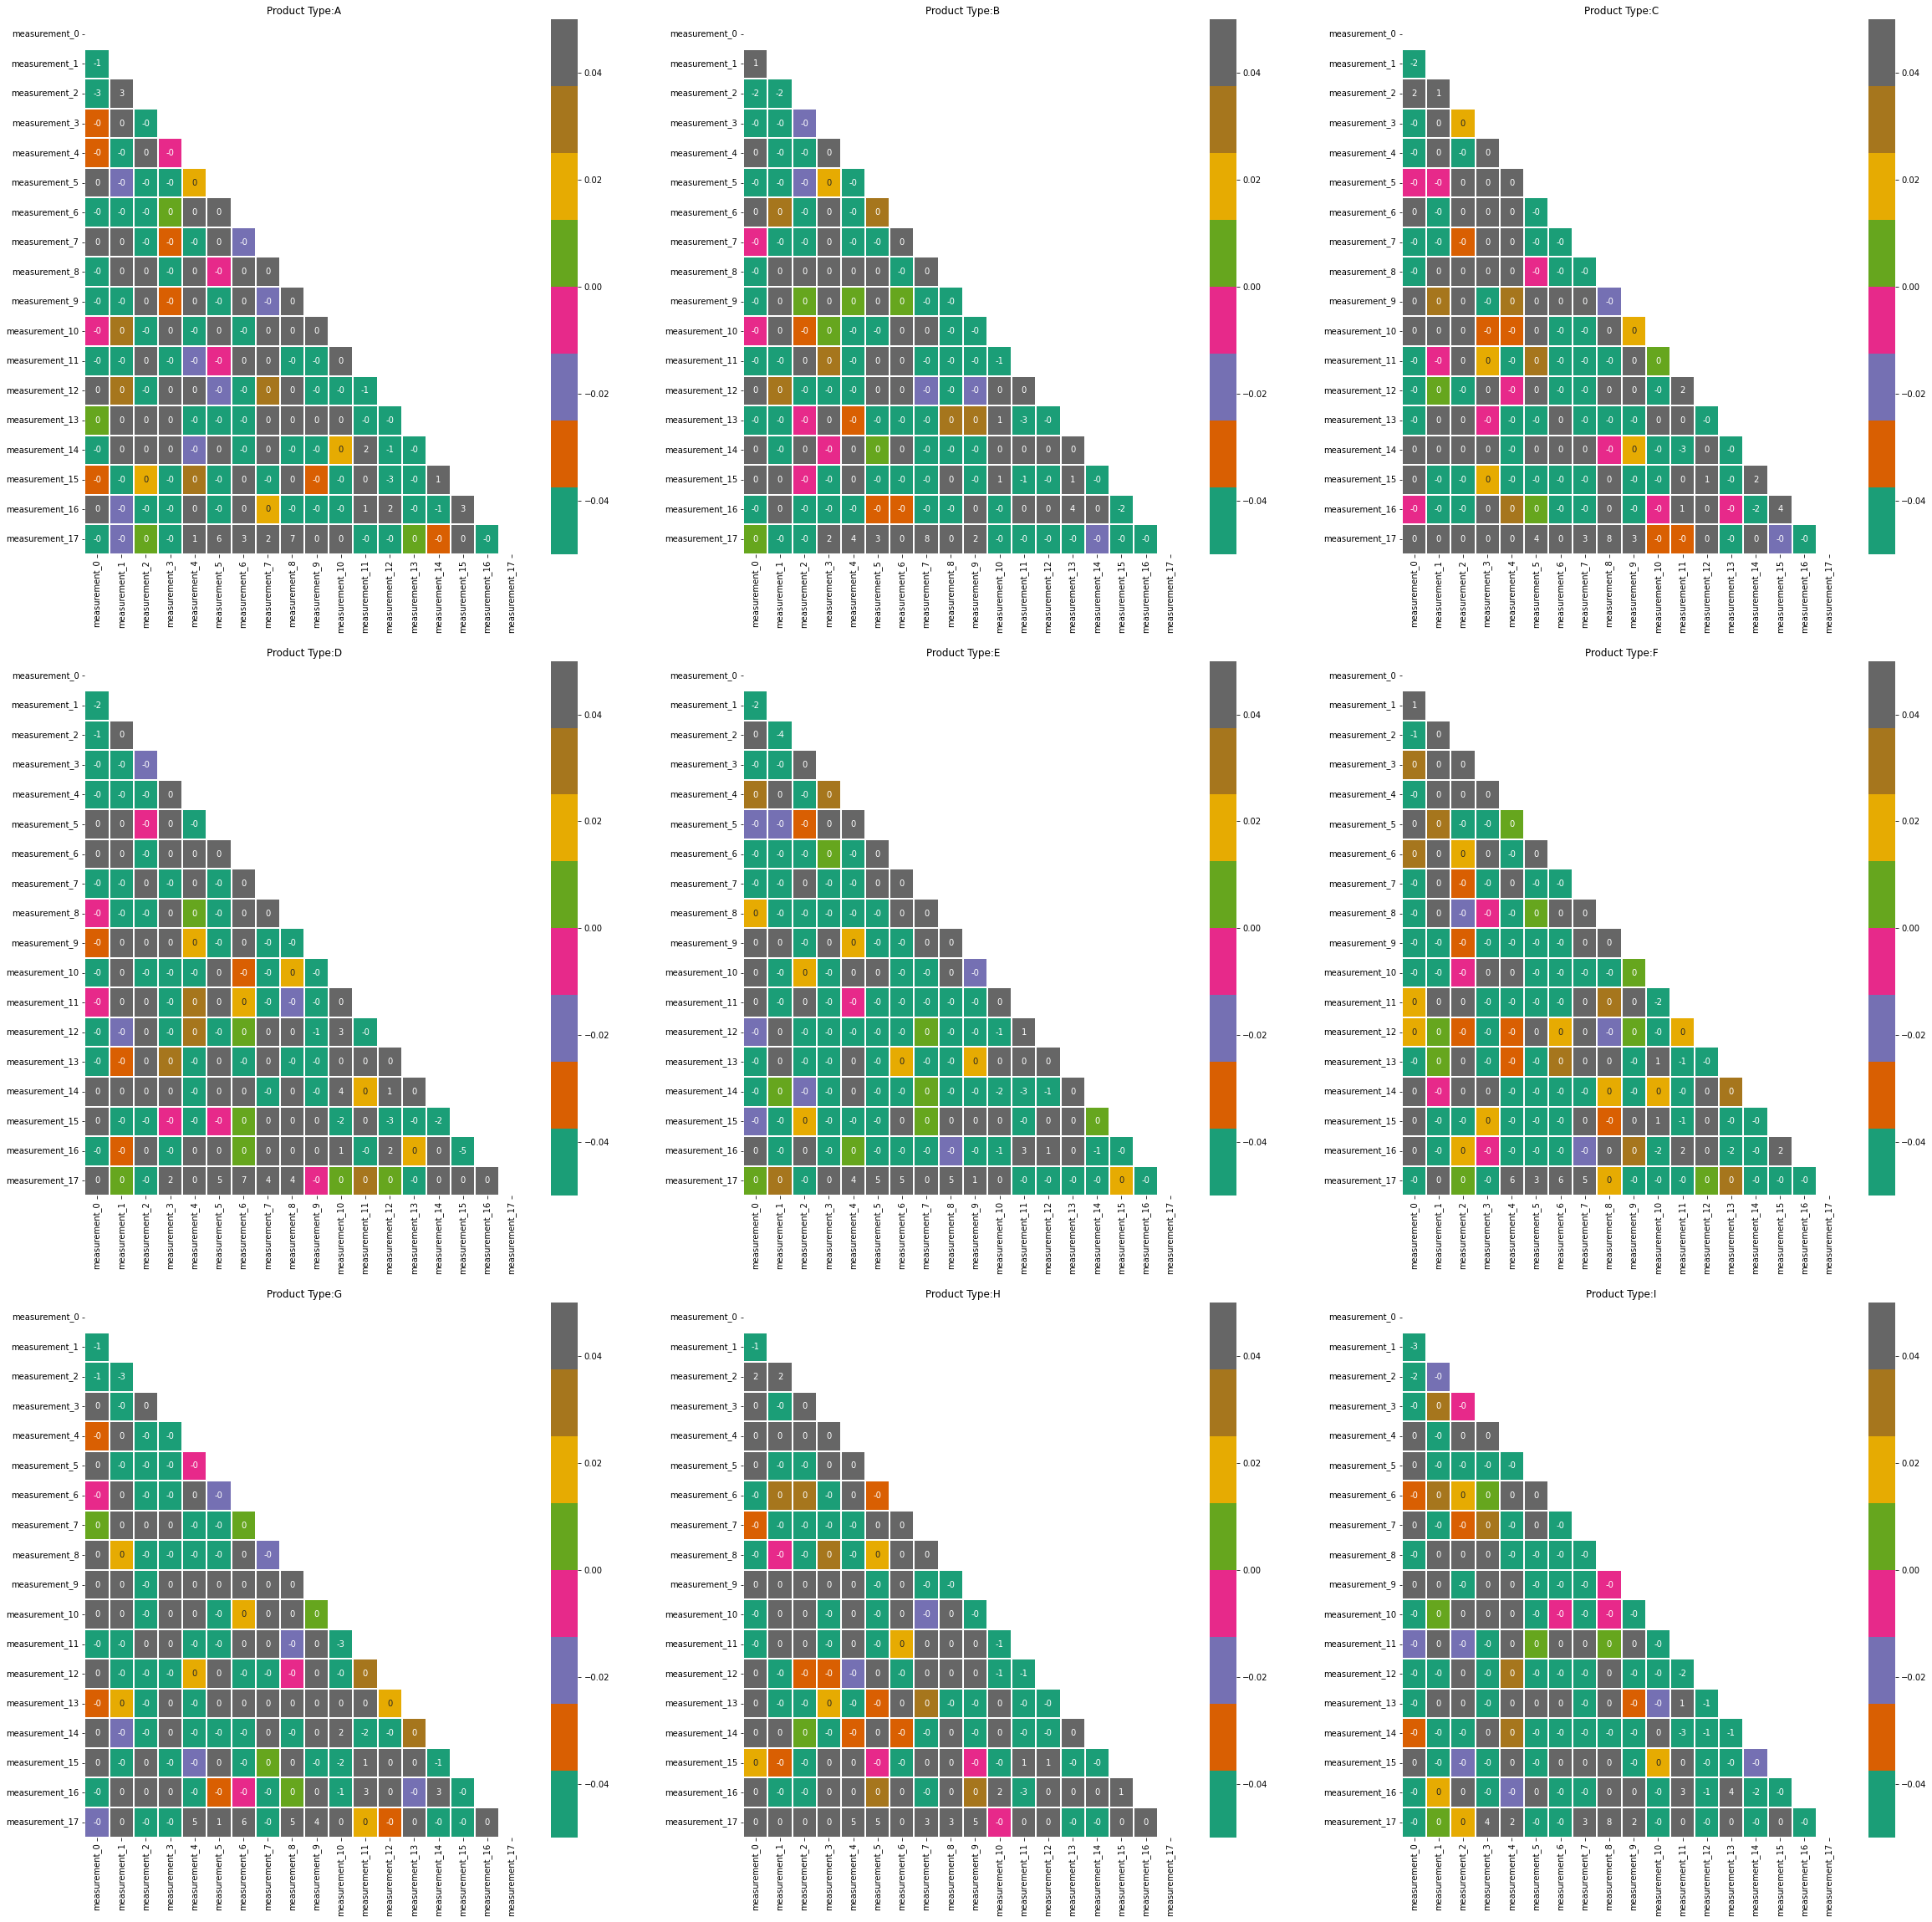

In [41]:
# Measurments Corrlation
fig, axes = plt.subplots(figsize=(40,40))
for  n, p_type in enumerate(product_types):
    plt.subplot(3,3,n+1)
    matrix = np.triu(measured_data.loc[data['product_code'] == str(p_type)].corr())
    sns.heatmap(measured_data.loc[data['product_code'] == str(p_type)].corr() *10 , annot= True , cmap="Dark2" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05 ,fmt='.0f' , vmax= 0.05 ,linewidths=0.1)
    plt.title("Product Type:" + str(p_type))
plt.show()

In [42]:
measurment_missings = pd.concat([data.isna().sum().rename('missing values in train'),
           round(data.isna().sum() / len(data) * 100,2).rename("Missin Rate Train")],
          axis=1)
measurment_missings

,missing values in train,Missin Rate Train
product_code,0,0.0
loading,473,1.0
attribute_0,0,0.0
attribute_1,0,0.0
attribute_2,0,0.0
attribute_3,0,0.0
measurement_0,0,0.0
measurement_1,0,0.0
measurement_2,0,0.0
measurement_3,710,1.5


<AxesSubplot:>

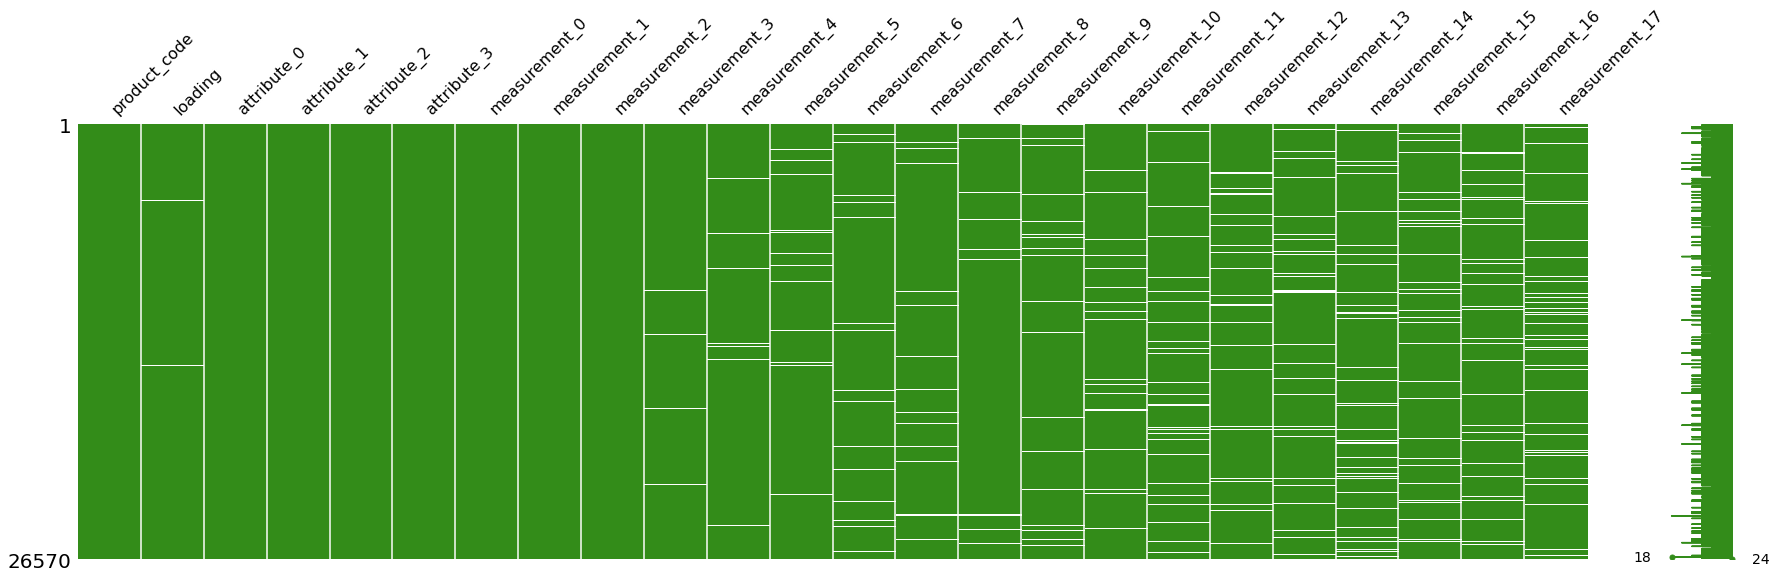

In [43]:
# Train Null Values
import missingno as msno
msno.matrix(train_df[all_features], color=(0.2, 0.55, 0.1), figsize=(30, 8))

<AxesSubplot:>

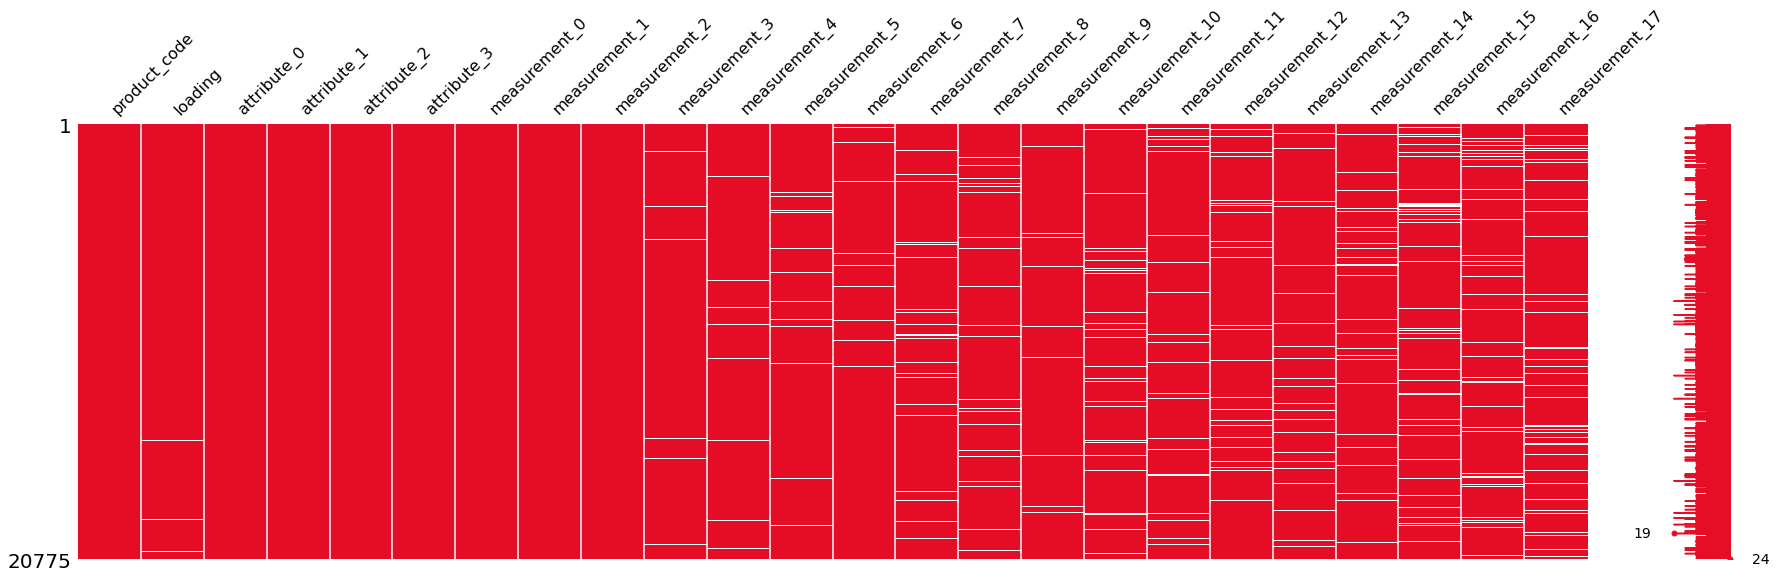

In [44]:
# Test Null Values
msno.matrix(test_df[all_features], color=(0.9, 0.05, 0.15), figsize=(30, 8))

In [45]:
# Total Null Percentage 
data_missing_percentage = data[cont_columns].isna().any(axis=1).sum() / len(data)
print(f' Total Missing percentage : {round(data_missing_percentage,2)} %',end='')

 Total Missing percentage : 0.54 %

Text(0.5, 1.0, 'Heatmap of missing values')

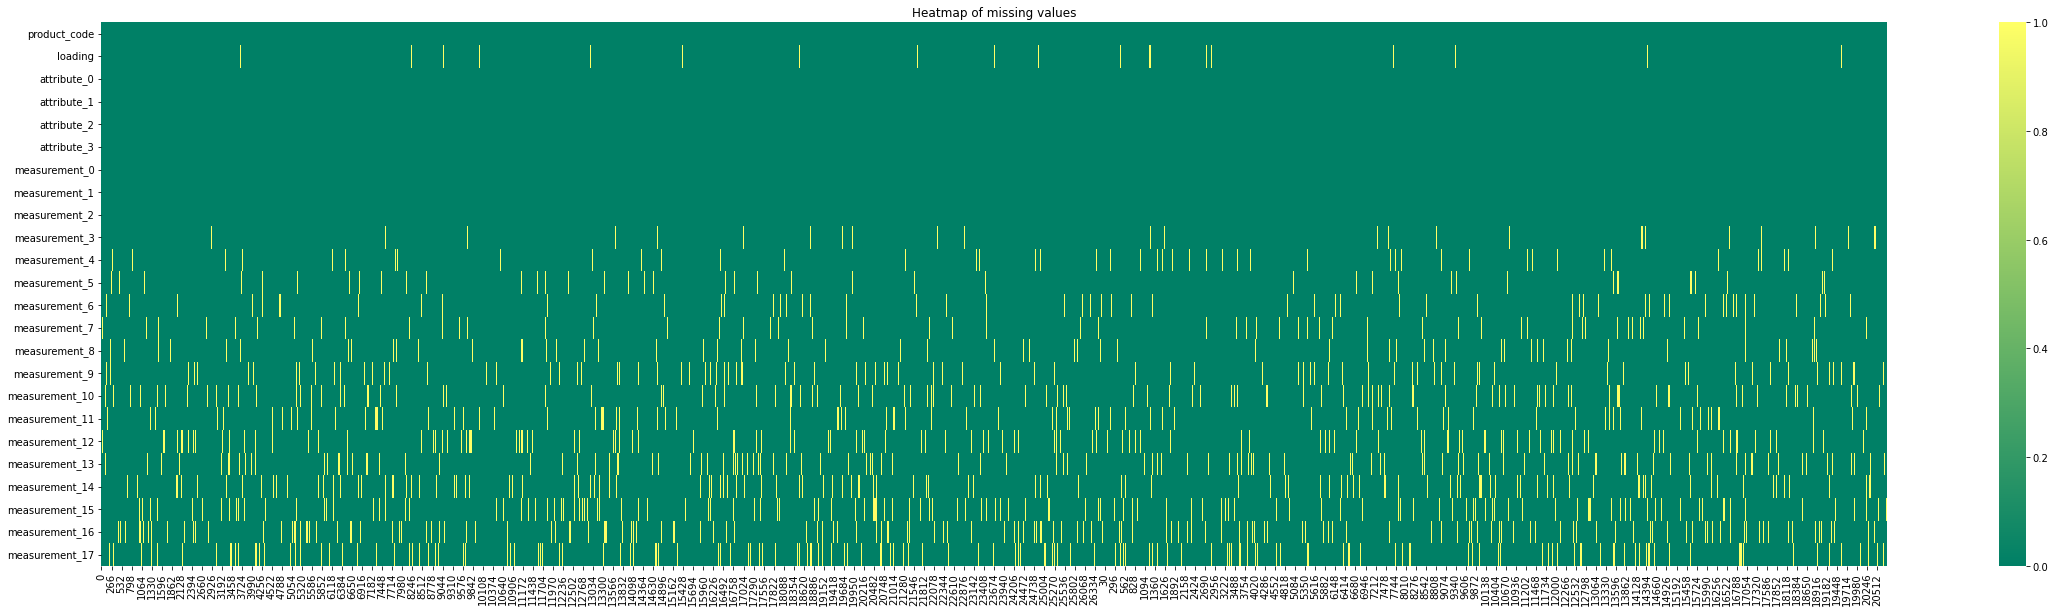

In [46]:
# Total Null Heatmap
plt.figure(figsize=(40,10))
sns.heatmap(data.isna().T, cmap='summer')
plt.title('Heatmap of missing values')

In [47]:
import scipy

feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

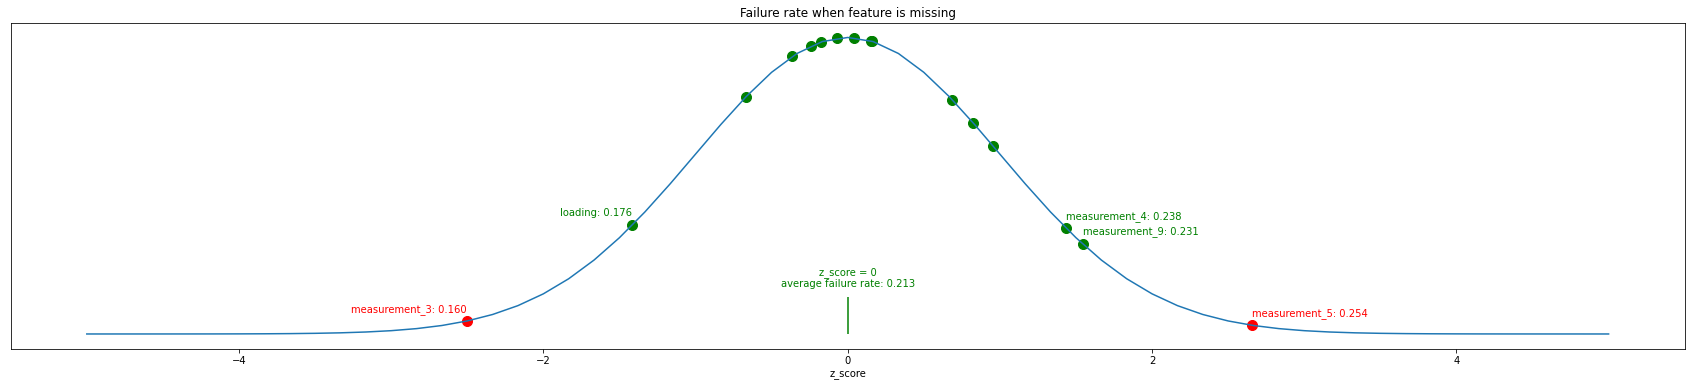

In [48]:
plt.figure(figsize=(30,6))
z_ticks = np.linspace(-5, 5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('feature           fail   miss   failure rate       z    p-value')
for f in train_df.columns:
    if train_df[f].isna().sum() > 0:
        total = train_df[f].isna().sum()
        fail = train_df[train_df[f].isna()].failure.sum()
        z = (fail / total - 0.212608) / (np.sqrt(0.212608 * (1-0.212608)) / np.sqrt(total))
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

In [49]:
data[obj_columns + ["attribute_2","attribute_3"]].drop_duplicates().set_index("product_code")

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


In [50]:
train_df["measurment_3_missing"] = train_df.measurement_3.isna()
test_df["measurment_3_missing"] = test_df.measurement_3.isna()

train_df["measurment_5_missing"] = train_df.measurement_5.isna()
test_df["measurment_5_missing"] = test_df.measurement_5.isna()



In [51]:
data["measurment_3_missing"] = data.measurement_3.isna()
data["measurment_5_missing"] = data.measurement_5.isna()
data['A2X3'] = data['attribute_2'] * data['attribute_3']
data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurment_3_missing,measurment_5_missing,A2X3
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,17.594,15.193,15.029,NaN,13.034,14.684,764.100,False,False,45
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.915,11.755,14.732,15.425,14.395,15.631,682.057,False,False,45
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,NaN,13.798,16.711,18.631,14.094,17.946,663.376,False,False,45
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,18.377,10.020,15.250,15.562,16.154,17.172,826.282,False,False,45
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,19.932,12.428,16.182,12.760,13.153,16.412,579.885,False,False,45


In [52]:
auc_list = []
test_pred_list = []
importance_list = []


kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_df, train_df.failure, train_df.product_code)):
    X_tr = train_df.iloc[idx_tr][test_df.columns]
    X_va = train_df.iloc[idx_va][test_df.columns]
    X_te = test_df.copy()
    y_tr = train_df.iloc[idx_tr].failure
    y_va = train_df.iloc[idx_va].failure

    # One Hot Encoder
    ohe_attributes = ['attribute_0', 'attribute_1']
    ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    ohe = OneHotEncoder(categories=[['material_5', 'material_7'],['material_5', 'material_6', 'material_8']],drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(X_tr[ohe_attributes])
    
    for df in [X_tr, X_va, X_te]:
        with warnings.catch_warnings(): # ignore "Found unknown categories"
            warnings.filterwarnings('ignore', category=UserWarning)
            df[ohe_output] = ohe.transform(df[ohe_attributes])
        df.drop(columns=ohe_attributes, inplace=True)
        

    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])
        
    # Remove Value smaller than 11 for measure_2
    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)
    

    # We fit a model
    features2 = [f for f in X_tr.columns if f != 'product_code']
    model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=0.01,solver='liblinear', random_state=42))
    model.fit(X_tr[features2], y_tr)        
    importance_list.append(model.named_steps['logisticregression'].coef_.ravel())
    

    # We validate the model
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    test_pred_list.append(model.predict_proba(X_te[features2])[:,1])


    
print(f"Average auc = {sum(auc_list) / len(auc_list):.5f}")


Fold 0: auc = 0.58827
Fold 1: auc = 0.58291
Fold 2: auc = 0.59105
Fold 3: auc = 0.59753
Fold 4: auc = 0.59675
Average auc = 0.59130


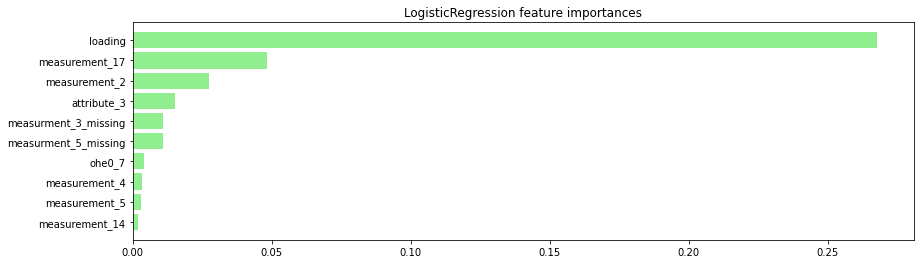

In [53]:
# Show feature importances
importance_df = pd.DataFrame(np.array(importance_list).T, index=features2)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = features2
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
plt.figure(figsize=(14, 4))
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

In [54]:
auc_list = []
test_pred_list = []
kf = GroupKFold(n_splits=5) # must be 5 because of the 5 product codes
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_df, train_df.failure, train_df.product_code)):
    X_tr = train_df.iloc[idx_tr][test_df.columns]
    X_va = train_df.iloc[idx_va][test_df.columns]
    X_te = test_df.copy()
    y_tr = train_df.iloc[idx_tr].failure
    y_va = train_df.iloc[idx_va].failure
    
    # One Hot Encoder
    ohe_attributes = ['attribute_0', 'attribute_1']
    ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
    ohe = OneHotEncoder(categories=[['material_5', 'material_7'],['material_5', 'material_6', 'material_8']],drop='first', sparse=False, handle_unknown='ignore')
    ohe.fit(X_tr[ohe_attributes])


    for df in [X_tr, X_va, X_te]:
        with warnings.catch_warnings(): # ignore "Found unknown categories"
            warnings.filterwarnings('ignore', category=UserWarning)
            df[ohe_output] = ohe.transform(df[ohe_attributes])
        df.drop(columns=ohe_attributes, inplace=True)
    
    
    # We fill the missing values
    features = [f for f in X_tr.columns if f == 'loading' or f.startswith('measurement')]
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X_tr[features])
    for df in [X_tr, X_va, X_te]:
        df[features] = imputer.transform(df[features])


    for df in [X_tr, X_va, X_te]:
        df['measurement_2'] = df['measurement_2'].clip(11, None)
        

    features2 = ['loading', 'attribute_3', 'measurement_2', 'measurement_4', 'measurement_17', 'measurment_3_missing', 'measurment_5_missing']
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_tr[features2], y_tr)
    with np.printoptions(linewidth=150, precision=2, suppress=True):
        print(model.named_steps['logisticregression'].coef_)
    
    y_va_pred = model.predict_proba(X_va[features2])[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)

    test_pred_list.append(model.predict_proba(X_te[features2])[:,1])

print(f"Average auc = {sum(auc_list) / len(auc_list):.5f}")

[[ 0.3  -0.06  0.06 -0.03  0.09 -0.04  0.03]]
Fold 0: auc = 0.59041
[[ 0.3  -0.05  0.06 -0.02  0.09 -0.02  0.05]]
Fold 1: auc = 0.58503
[[ 0.29 -0.04  0.03 -0.04  0.08 -0.06  0.04]]
Fold 2: auc = 0.59351
[[ 0.29 -0.05  0.05 -0.05  0.08 -0.06  0.03]]
Fold 3: auc = 0.59812
[[ 0.29 -0.02  0.06 -0.03  0.1  -0.04  0.04]]
Fold 4: auc = 0.59641
Average auc = 0.59270


In [55]:
submission = pd.DataFrame({'id': test_df.id,'failure': sum(test_pred_list)/len(test_pred_list)})
submission.to_csv('submission_four_features.csv', index=False)
submission

,id,failure
0,26570,0.213512
1,26571,0.185199
2,26572,0.205256
3,26573,0.196232
4,26574,0.354649
...,...,...
20770,47340,0.234280
20771,47341,0.156401
20772,47342,0.153990
20773,47343,0.223727
